### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime

from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import xgboost as xgb

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

### Data Import

In [2]:
train = pd.read_parquet("train_data.parquet", engine="fastparquet")
test = pd.read_parquet("test_data.parquet", engine="fastparquet")
df = pd.concat([train, test], axis=0).reset_index(drop=True)

### Functions

In [3]:
def plot_cm(y_true, y_pred, classes, title="Confusion Matrix", normalize=False):
    """Plots the confusion matrix as heatmap

    Parameters
    ----------
    y_true : ArrayLike
        Ground truth (correct) target values, array-like of shape (n_samples,)
    y_pred : ArrayLike
        Estimated targets as returned by a classifier, array-like of shape (n_samples,)
    classes : List[str]
        array of class labels
    title : str, optional
        Title of the heatmap, by default "Confusion Matrix"
    normalize : bool, optional
        If True, normalizes the confusion matrix, by default False

    Returns
    -------
    cm : ndarray
        Confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fmt = ".3f" if normalize else "g"
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        fmt=fmt,
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return cm

In [4]:
def perform_model(
    model, X_train, y_train, X_test, y_test, classes, cm_normalize=True, print_cr=False
):
    """Performs the following steps in sequence
    1. Trains the model
    2. Predicts the test data
    3. Calculates the accuracy score
    4. Plots the confusion matrix
    5. Prints the classification report

    Parameters
    ----------
    model : estimator object
        The object to use to fit the data.
    X_train : ArrayLike
        Training data
    y_train : ArrayLike
        True labels for X_train
    X_test : ArrayLike
        Testing data
    y_test : ArrayLike
        True labels for X_test
    classes : List[str]
        array of class labels
    cm_normalize : bool, optional
        If True, normalizes the confusion matrix, by default True
    print_cr : bool, optional
        If True, prints the classification report, by default False

    Returns
    -------
    res : dict
        Dictionary containing the results of the model
    """
    res = {}

    start_time = datetime.now()
    model.fit(X_train, y_train)
    res["train_time"] = datetime.now() - start_time
    print(f"==> Train time:- {res['train_time']}")

    start_time = datetime.now()
    y_pred = model.predict(X_test)
    res["test_time"] = datetime.now() - start_time
    print(f"==> Test time:- {res['test_time']}")
    res["predicted"] = y_pred

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    res["accuracy"] = accuracy
    print(f"==> Accuracy:- {accuracy}")
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
    res["f1_score"] = f1
    print(f"==> F1 Score:- {f1}")

    res["confusion_matrix"] = plot_cm(
        y_test,
        y_pred,
        classes=classes,
        title="Confusion Matrix",
        normalize=cm_normalize,
    )

    cr = classification_report(y_test, y_pred)
    res["classification_report"] = cr
    if print_cr:
        print("Classification Report")
        print(cr)

    res["model"] = model

    return res

In [5]:
def print_grid_search_attributes(model):
    """Prints the GridSearch attributes of the model

    Parameters
    ----------
    model : estimator object
    """
    print("==> Best parameters:")
    print(f"\tParameters of best estimator : {model.best_params_}")
    print("==> No. of CrossValidation sets:")
    print(f"\tTotal number of cross validation sets: {model.n_splits_}")
    print("==> Best Score:")
    print(f"\tAverage Cross Validate scores of best estimator : {model.best_score_}")

## Data Preparation

In [6]:
X, y = df.iloc[:, :-2], df.iloc[:, -1:]
X_train, y_train = train.iloc[:, :-2], train.iloc[:, -1:]
X_test, y_test = test.iloc[:, :-2], test.iloc[:, -1:]

labels = df["activity"].unique()
activities_encoder = LabelEncoder()
y = activities_encoder.fit_transform(y)
y_train = activities_encoder.transform(y_train)
y_test = activities_encoder.transform(y_test)

## Feature Exploration

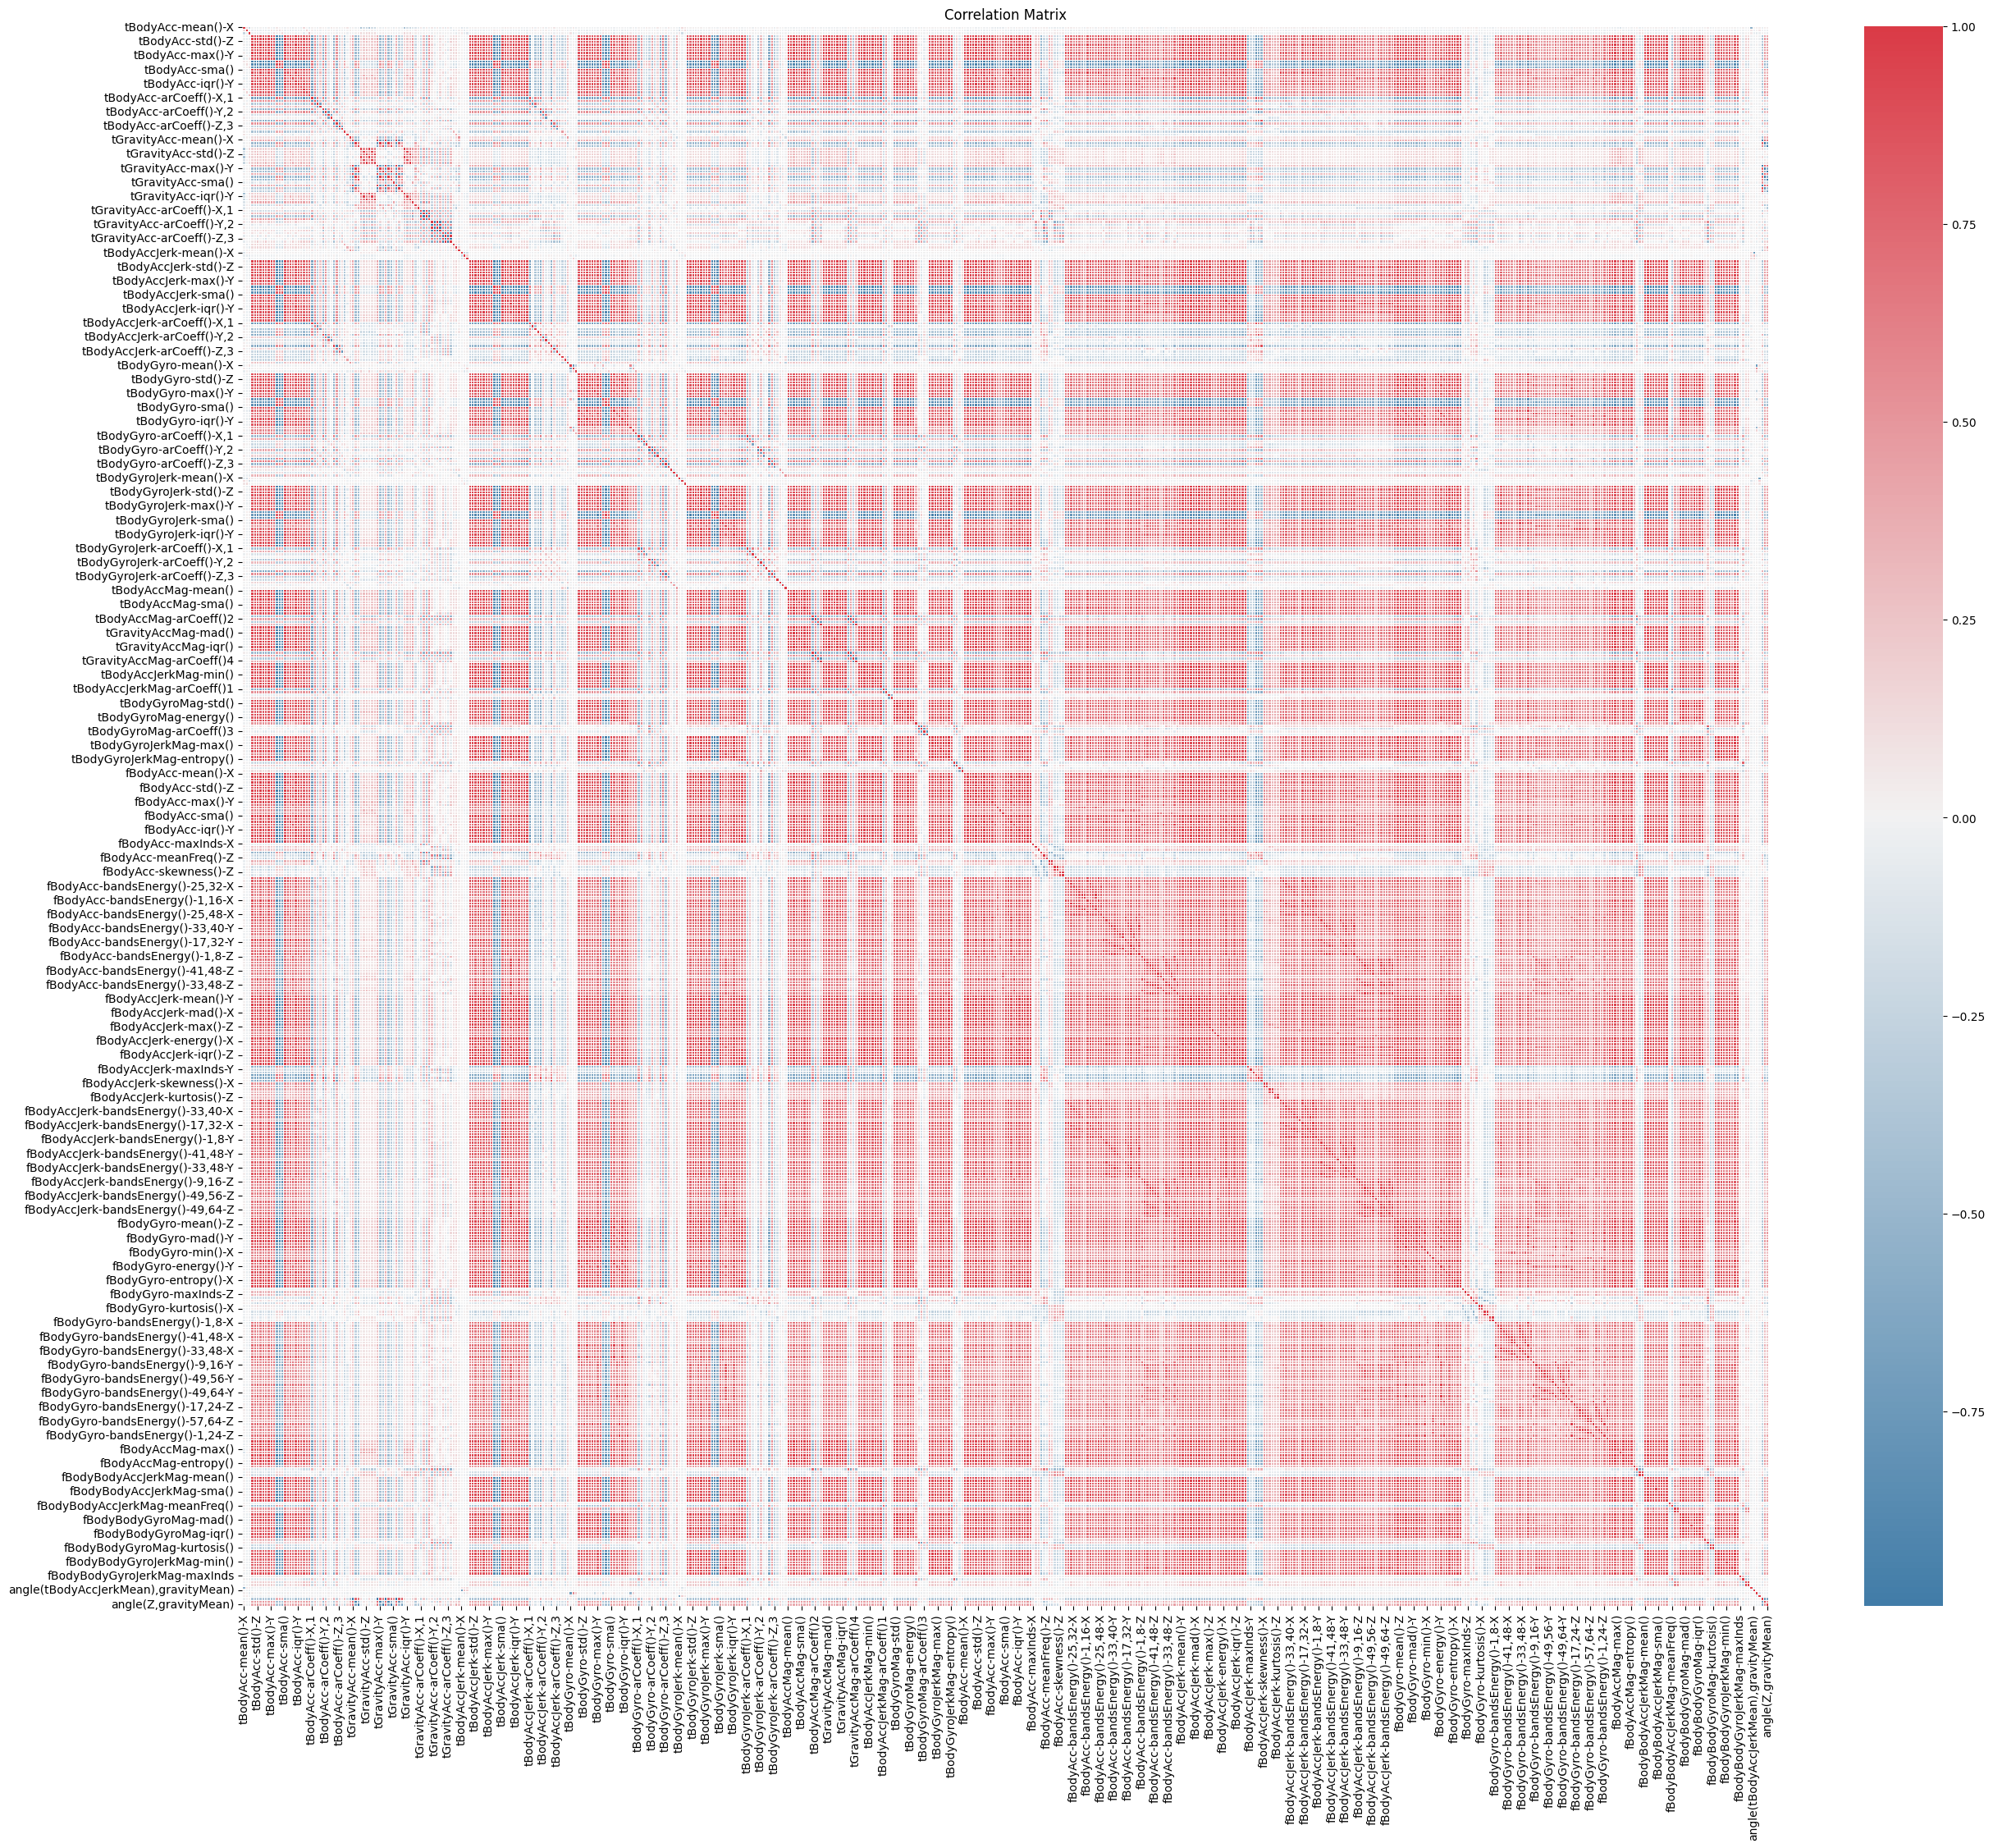

In [51]:
correlation_matrix = X.corr()
plt.figure(figsize=(30, 25))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(correlation_matrix, cmap=cmap, center=0, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Feature Engineering

In [7]:
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, test_size=0.85, random_state=42, stratify=y_train
)
X_test_sample, _, y_test_sample, _ = train_test_split(
    X_test, y_test, test_size=0.85, random_state=42, stratify=y_test
)

### Recursive Feature Elimination

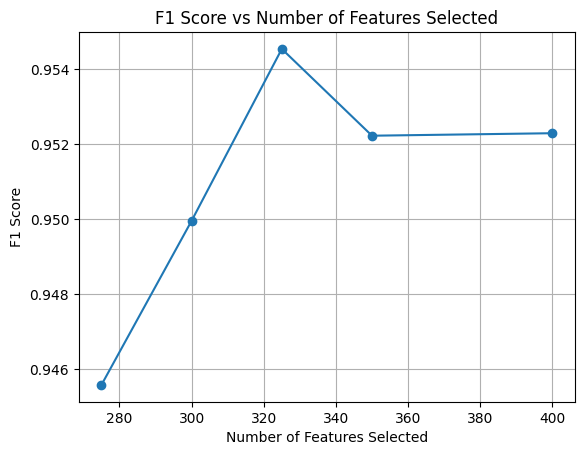

In [8]:
n_features_range = [275, 300, 325, 350, 400]
f1_scores = []

for n_features in n_features_range:
    estimator = LogisticRegression()
    rfe = RFE(estimator, n_features_to_select=n_features)

    rfe.fit(X_train_sample, y_train_sample)
    selected_features = X.columns[rfe.support_]
    estimator.fit(X_train_sample[selected_features], y_train_sample)
    y_pred = estimator.predict(X_test_sample[selected_features])
    f1_scores.append(f1_score(y_test_sample, y_pred, average="weighted"))

plt.plot(n_features_range, f1_scores, marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Number of Features Selected")
plt.grid(True)
plt.show()

### Variance Threshold

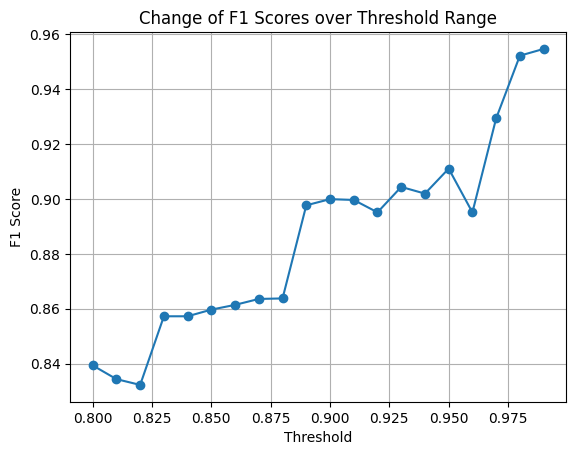

In [9]:
corr_matrix = X_train.corr().abs()
threshold_range = np.arange(0.8, 1.0, 0.01)
f1_scores = []
for threshold in threshold_range:
    correlated_features = []
    n_features = corr_matrix.shape[1]
    columns = corr_matrix.columns

    for i in range(n_features):
        for j in range(i + 1, n_features):
            if corr_matrix.iloc[i, j] >= threshold:
                correlated_features.append((columns[i], columns[j]))

    correlated_features = list(
        set([item for sublist in correlated_features for item in sublist])
    )
    X_vt_selected = X_train_sample.drop(correlated_features, axis=1)

    model = LogisticRegression()
    model.fit(X_vt_selected, y_train_sample)
    y_pred = model.predict(X_test_sample.drop(correlated_features, axis=1))
    f1_scores.append(f1_score(y_test_sample, y_pred, average="weighted"))

plt.plot(threshold_range, f1_scores, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Change of F1 Scores over Threshold Range")
plt.grid(True)
plt.show()

### Principal Component Analysis

Selecting best number of components

180


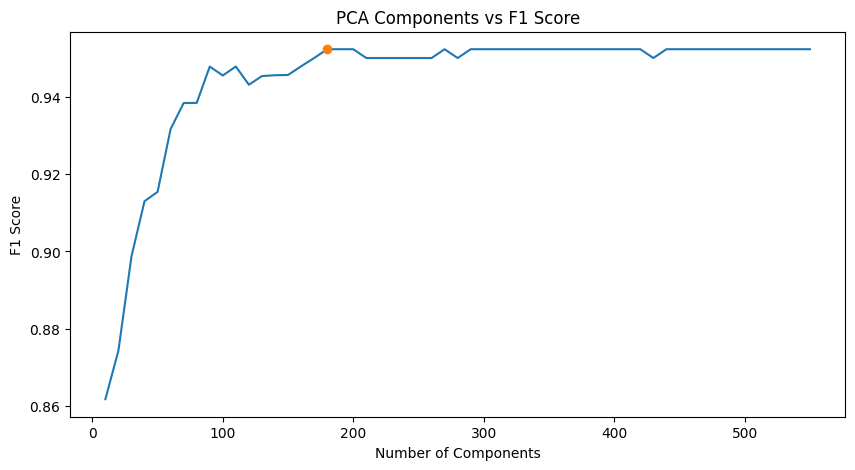

In [10]:
n_components_list = range(10, 560, 10)
f1_scores = []

for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca.fit(X_train_sample)

    X_train_pca = pca.transform(X_train_sample)
    X_test_pca = pca.transform(X_test_sample)

    model = LogisticRegression()
    model.fit(X_train_pca, y_train_sample)

    y_pred_pca = model.predict(X_test_pca)
    f1_scores.append(f1_score(y_test_sample, y_pred_pca, average="weighted"))

print(n_components_list[np.argmax(f1_scores)])

plt.figure(figsize=(10, 5))
plt.plot(n_components_list, f1_scores)
plt.plot(n_components_list[np.argmax(f1_scores)], max(f1_scores), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("F1 Score")
plt.title("PCA Components vs F1 Score")
plt.show()

190


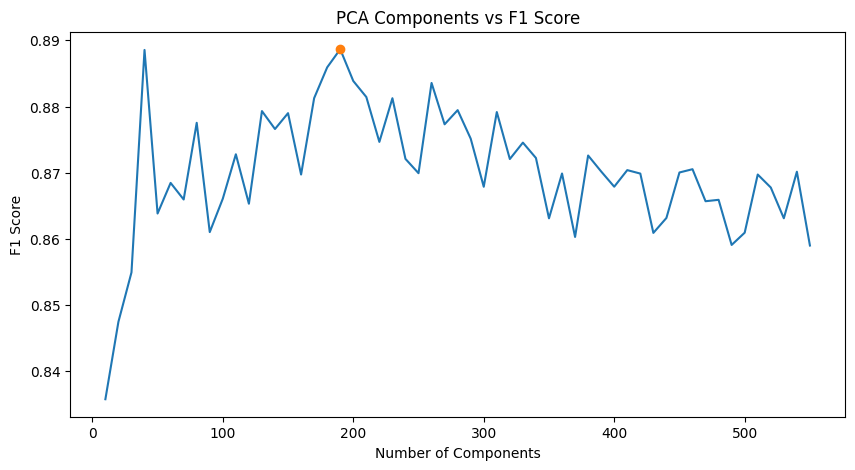

In [11]:
n_components_list = range(10, 560, 10)
f1_scores = []

for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca.fit(X_train_sample)

    X_train_pca = pca.transform(X_train_sample)
    X_test_pca = pca.transform(X_test_sample)

    model = xgb.XGBClassifier()
    model.fit(X_train_pca, y_train_sample)

    y_pred_pca = model.predict(X_test_pca)
    f1_scores.append(f1_score(y_test_sample, y_pred_pca, average="weighted"))

print(n_components_list[np.argmax(f1_scores)])

plt.figure(figsize=(10, 5))
plt.plot(n_components_list, f1_scores)
plt.plot(n_components_list[np.argmax(f1_scores)], max(f1_scores), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("F1 Score")
plt.title("PCA Components vs F1 Score")
plt.show()

### PCA + RFE

In [12]:
estimator = LogisticRegression()
rfe = RFE(estimator, n_features_to_select=350)
rfe.fit(X_train_sample, y_train_sample)
selected_features = X_train_sample.columns[rfe.support_]
X_train_rfe_sample = X_train_sample[selected_features]
X_test_rfe_sample = X_test_sample[selected_features]

Best Number of Components: 180


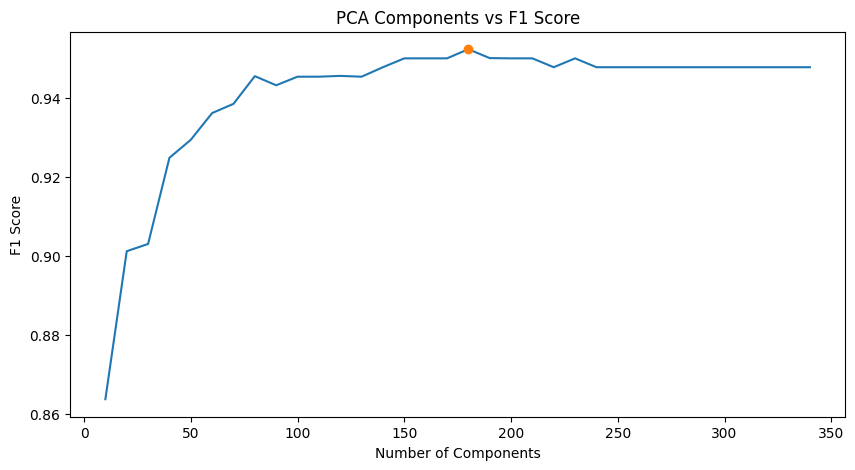

In [13]:
n_components_list = range(10, 350, 10)
f1_scores = []

for n_components in n_components_list:
    pca = PCA(n_components=n_components)

    X_train_rfepca = pca.fit_transform(X_train_rfe_sample)
    X_test_rfepca = pca.transform(X_test_rfe_sample)

    model = LogisticRegression()
    model.fit(X_train_rfepca, y_train_sample)

    y_pred_rfepca = model.predict(X_test_rfepca)
    f1_scores.append(f1_score(y_test_sample, y_pred_rfepca, average="weighted"))

print(f"Best Number of Components: {n_components_list[np.argmax(f1_scores)]}")
plt.figure(figsize=(10, 5))
plt.plot(n_components_list, f1_scores)
plt.plot(n_components_list[np.argmax(f1_scores)], max(f1_scores), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("F1 Score")
plt.title("PCA Components vs F1 Score")
plt.show()

### Final

In [8]:
pca = PCA(n_components=170)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [9]:
estimator = LogisticRegression()
rfe = RFE(estimator, n_features_to_select=325)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]

In [11]:
corr_matrix = X_train.corr().abs()
threshold = 1
correlated_features = []
n_features = corr_matrix.shape[1]
columns = corr_matrix.columns
for i in range(n_features):
    for j in range(i + 1, n_features):
        if corr_matrix.iloc[i, j] >= threshold:
            correlated_features.append((columns[i], columns[j]))
correlated_features = list(
    set([item for sublist in correlated_features for item in sublist])
)

In [12]:
pca = PCA(n_components=180)
X_train_rfepca = pca.fit_transform(X_train[selected_features])
X_test_rfepca = pca.transform(X_test[selected_features])

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Models

### Logistic Regression

Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:11.139807
==> Test time:- 0:00:00.007998
==> Accuracy:- 0.9582626399728538
==> F1 Score:- 0.9581227725191673


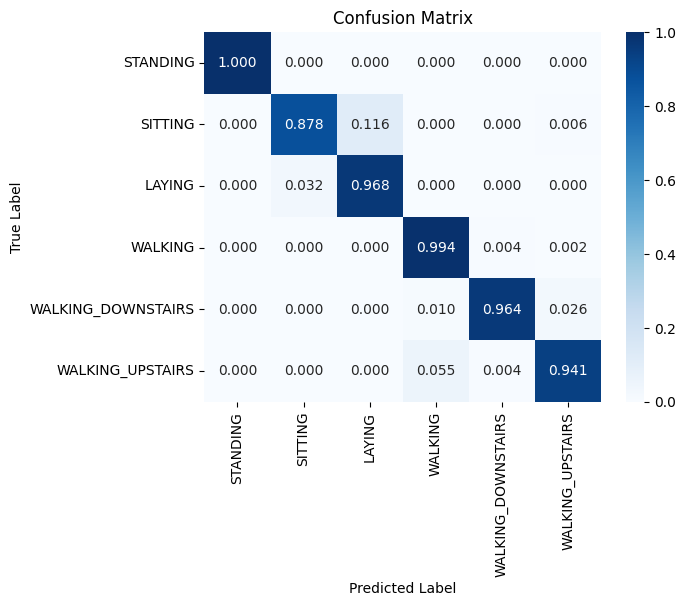

==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9371615639319785


In [19]:
parameters = {"C": [0.1, 1, 10, 20, 30], "penalty": ["l2", "l1"]}
log_reg = LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results = perform_model(
    log_reg_grid, X_train, y_train, X_test, y_test, classes=labels, cm_normalize=True
)

print_grid_search_attributes(log_reg_grid_results["model"])

w/ Scaler

Fitting 3 folds for each of 10 candidates, totalling 30 fits


==> Train time:- 0:00:08.031580
==> Test time:- 0:00:00.004000
==> Accuracy:- 0.9541907024092298
==> F1 Score:- 0.9541121351699685


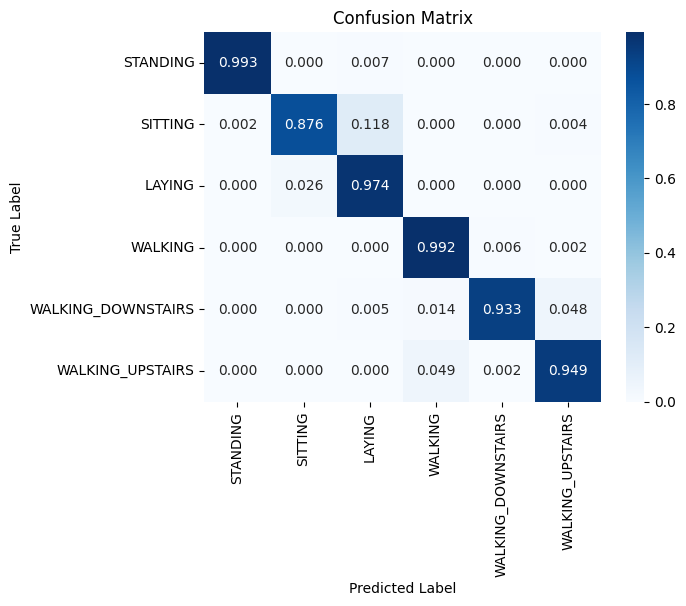

==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9387945500517629


In [20]:
parameters = {"C": [0.1, 1, 10, 20, 30], "penalty": ["l2", "l1"]}
scaled_log_reg = LogisticRegression()
scaled_log_reg_grid = GridSearchCV(
    scaled_log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1
)
scaled_log_reg_grid_results = perform_model(
    scaled_log_reg_grid,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(scaled_log_reg_grid_results["model"])

w/ RFE selection

Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:05.189383
==> Test time:- 0:00:00.004999
==> Accuracy:- 0.9596199524940617
==> F1 Score:- 0.9594723774033926


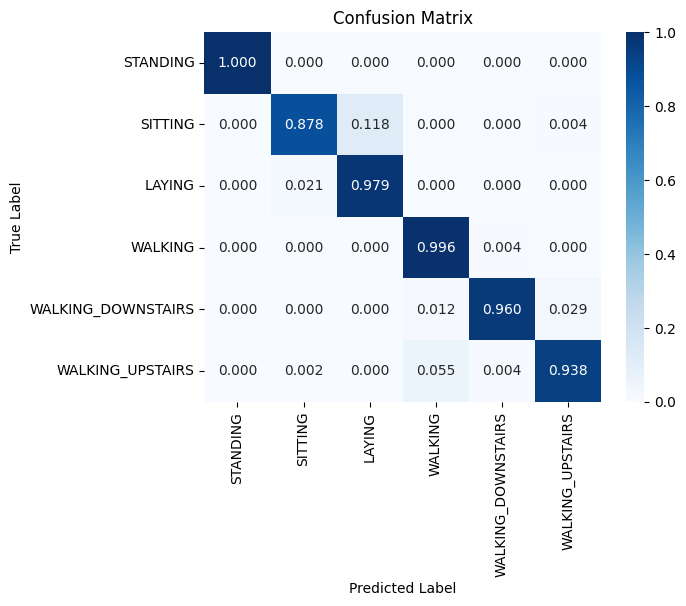

==> Best parameters:
	Parameters of best estimator : {'C': 10, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9465469876240991


In [21]:
parameters = {"C": [0.1, 1, 10, 20, 30], "penalty": ["l2", "l1"]}
rfe_log_reg = LogisticRegression()
rfe_log_reg_grid = GridSearchCV(
    rfe_log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1
)
rfe_log_reg_grid_results = perform_model(
    rfe_log_reg_grid,
    X_train[selected_features],
    y_train,
    X_test[selected_features],
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(rfe_log_reg_grid_results["model"])

w/ VT

Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:07.490692
==> Test time:- 0:00:00.008997
==> Accuracy:- 0.9579233118425518
==> F1 Score:- 0.957806786777658


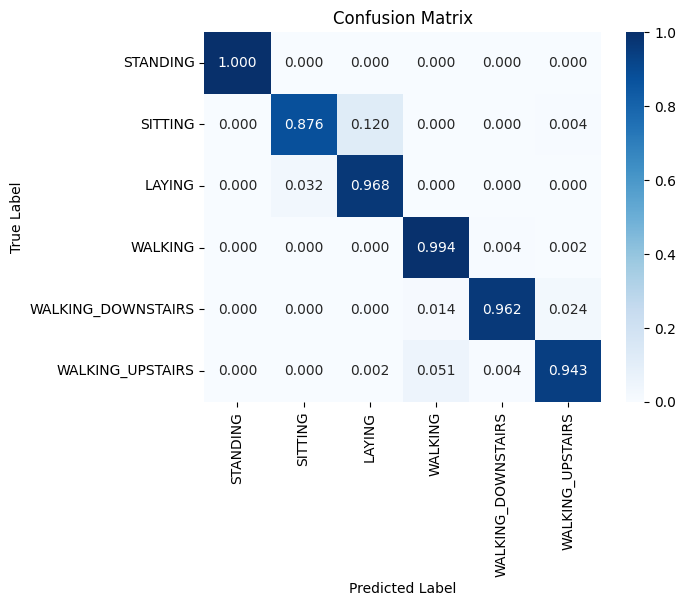

==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9368893995786808


In [22]:
parameters = {"C": [0.1, 1, 10, 20, 30], "penalty": ["l2", "l1"]}
vt_log_reg = LogisticRegression()
vt_log_reg_grid = GridSearchCV(
    vt_log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1
)
vt_log_reg_grid_results = perform_model(
    vt_log_reg_grid,
    X_train.drop(correlated_features, axis=1),
    y_train,
    X_test.drop(correlated_features, axis=1),
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(vt_log_reg_grid_results["model"])

w/ PCA

Fitting 3 folds for each of 10 candidates, totalling 30 fits


==> Train time:- 0:00:02.685527
==> Test time:- 0:00:00.002976
==> Accuracy:- 0.9613165931455717
==> F1 Score:- 0.9612057019424454


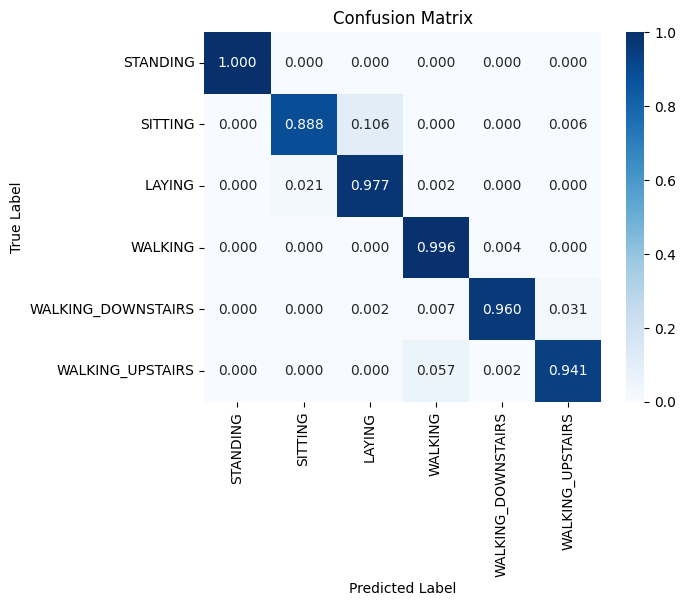

==> Best parameters:
	Parameters of best estimator : {'C': 10, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9393384346802777


In [23]:
parameters = {"C": [0.1, 1, 10, 20, 30], "penalty": ["l2", "l1"]}
pca_log_reg = LogisticRegression()
pca_log_reg_grid = GridSearchCV(
    pca_log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1
)
pca_log_reg_grid_results = perform_model(
    pca_log_reg_grid,
    X_train_pca,
    y_train,
    X_test_pca,
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(pca_log_reg_grid_results["model"])

w/ RFE + PCA

Fitting 3 folds for each of 10 candidates, totalling 30 fits


==> Train time:- 0:00:03.008000
==> Test time:- 0:00:00.000999
==> Accuracy:- 0.9586019681031558
==> F1 Score:- 0.9584560292975985


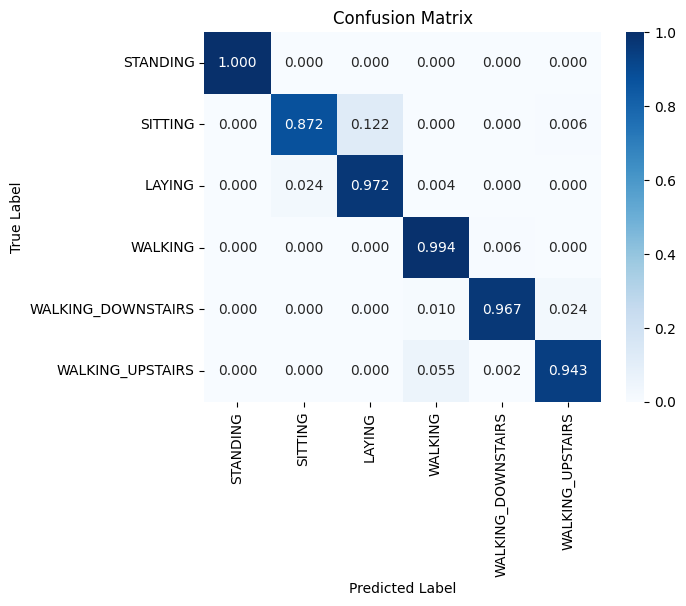

==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9462747677610416


In [24]:
parameters = {"C": [0.1, 1, 10, 20, 30], "penalty": ["l2", "l1"]}
rfepca_log_reg = LogisticRegression()
rfepca_log_reg_grid = GridSearchCV(
    rfepca_log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1
)
rfepca_log_reg_grid_results = perform_model(
    rfepca_log_reg_grid,
    X_train_rfepca,
    y_train,
    X_test_rfepca,
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(rfepca_log_reg_grid_results["model"])

### XGBoost

In [17]:
parameters = {
    "min_child_weight": [3, 4, 5],
    "gamma": [0.25],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "max_depth": [4, 5, 6],
}
gb = xgb.XGBClassifier()
gb_grid = GridSearchCV(gb, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
gb_grid_results = perform_model(
    gb_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(gb_grid_results["model"])

Fitting 3 folds for each of 81 candidates, totalling 243 fits


Fitting 3 folds for each of 1 candidates, totalling 3 fits
==> Train time:- 0:00:42.182261
==> Test time:- 0:00:00.005000
==> Accuracy:- 0.9328130302002036
==> F1 Score:- 0.9326107634617294


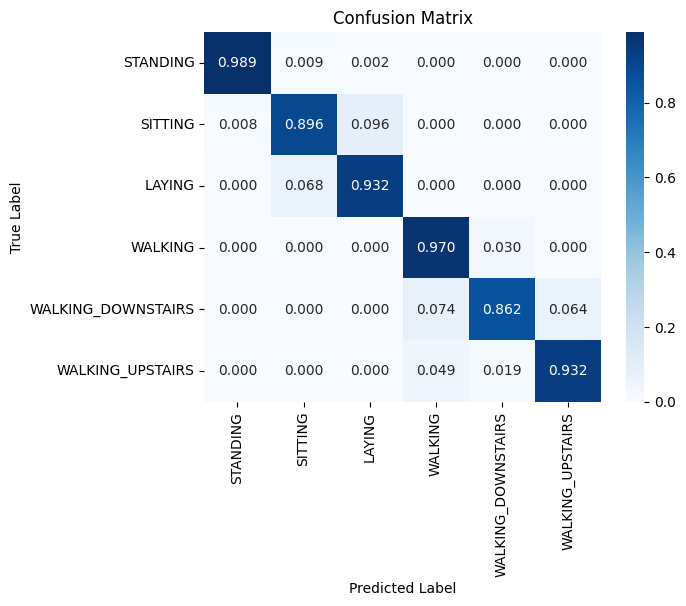

==> Best parameters:
	Parameters of best estimator : {'colsample_bytree': 0.8, 'gamma': 0.25, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.8945894636924537


In [ ]:
parameters = {
    "min_child_weight": [3, 4, 5],
    "gamma": [0.25],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "max_depth": [4, 5, 6],
}
gb = xgb.XGBClassifier()
gb_grid = GridSearchCV(gb, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
gb_grid_results = perform_model(
    gb_grid,
    X_train_pca,
    y_train,
    X_test_pca,
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(gb_grid_results["model"])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
==> Train time:- 0:00:44.790726
==> Test time:- 0:00:00.018001
==> Accuracy:- 0.9399389209365456
==> F1 Score:- 0.93982553977134


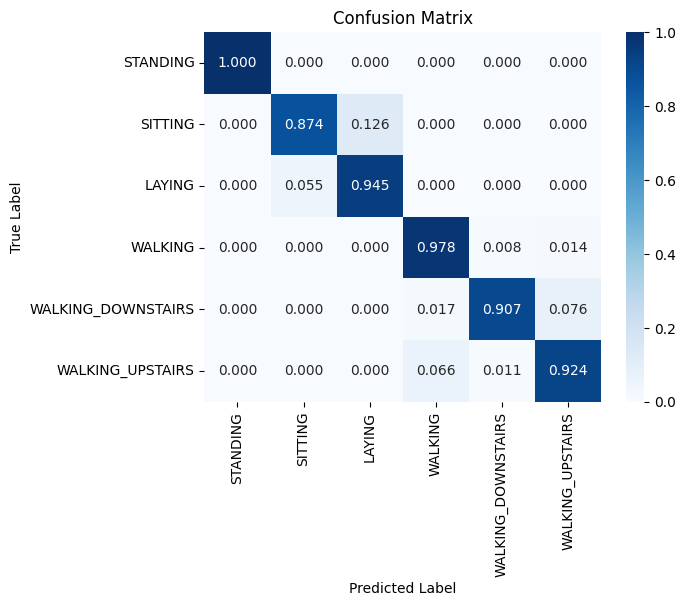

==> Best parameters:
	Parameters of best estimator : {'colsample_bytree': 0.8, 'gamma': 0.25, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9151284079523282


In [ ]:
parameters = {
    "min_child_weight": [3, 4, 5],
    "gamma": [0.25],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "max_depth": [4, 5, 6],
}
gb = xgb.XGBClassifier()
gb_grid = GridSearchCV(gb, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
gb_grid_results = perform_model(
    gb_grid,
    X_train[selected_features],
    y_train,
    X_test[selected_features],
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(gb_grid_results["model"])

### Neural Networks

In [72]:
def create_model():
    model = Sequential()
    model.add(Dense(64, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def create_model_rfe():
    model = Sequential()
    model.add(Dense(64, activation="relu", input_shape=(X_train_rfe.shape[1],)))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Fitting 3 folds for each of 9 candidates, totalling 27 fits
==> Train time:- 0:00:42.971944
93/93 [==============================] - 0s 1ms/step
==> Test time:- 0:00:00.400334
==> Accuracy:- 0.9280624363759755
==> F1 Score:- 0.9278651938868747



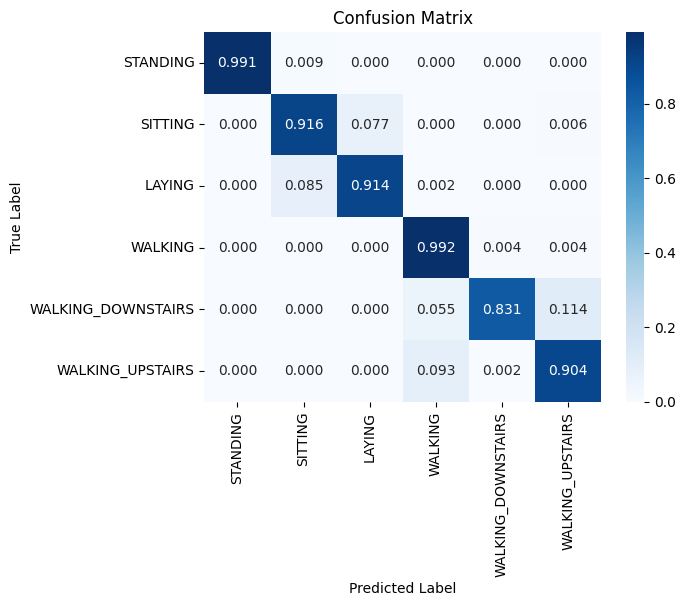

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       537
           1       0.90      0.92      0.91       491
           2       0.93      0.91      0.92       532
           3       0.88      0.99      0.93       496
           4       0.99      0.83      0.90       420
           5       0.89      0.90      0.90       471

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



==> Best Estimator:

==> Best parameters:
	Parameters of best estimator : {'batch_size': 16, 'epochs': 20}

==> No. of CrossValidation sets:
	Total number of cross validation sets: 3

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9364798069000244


In [81]:
parameters = {"epochs": [5, 10, 20], "batch_size": [16, 32, 64]}
nn = KerasClassifier(create_model, verbose=0)
nn_grid = GridSearchCV(nn_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
nn_grid_results = perform_model(
    nn_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(nn_grid_results["model"])

NN + RFE

Fitting 3 folds for each of 9 candidates, totalling 27 fits
==> Train time:- 0:00:26.675391
93/93 [==============================] - 0s 871us/step
==> Test time:- 0:00:00.254130
==> Accuracy:- 0.9429928741092637
==> F1 Score:- 0.9430469490543386



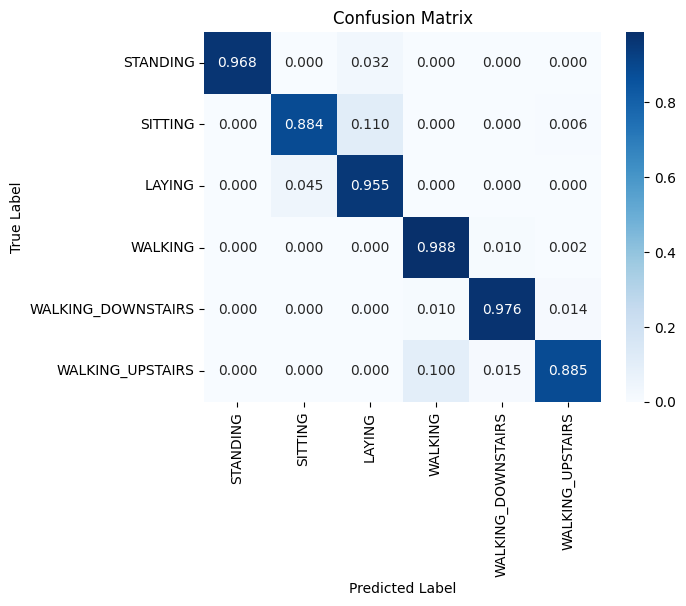

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       537
           1       0.95      0.88      0.91       491
           2       0.88      0.95      0.91       532
           3       0.91      0.99      0.95       496
           4       0.97      0.98      0.97       420
           5       0.98      0.89      0.93       471

    accuracy                           0.94      2947
   macro avg       0.95      0.94      0.94      2947
weighted avg       0.95      0.94      0.94      2947

==> Best parameters:
	Parameters of best estimator : {'batch_size': 64, 'epochs': 10}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9523934523264567


In [83]:
parameters = {"epochs": [5, 10, 20], "batch_size": [16, 32, 64]}
rfe_nn = KerasClassifier(create_model_rfe, verbose=0)
rfe_nn_grid = GridSearchCV(
    rfe_nn_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1
)
rfe_nn_grid_results = perform_model(
    rfe_nn_grid,
    X_train[selected_features],
    y_train,
    X_test[selected_features],
    y_test,
    classes=labels,
    cm_normalize=True,
)

print_grid_search_attributes(rfe_nn_grid_results["model"])